# Step 0: Load Data & Required Packages

In [2]:
# import required packages
import pandas as pd
import numpy as np
import os
from datetime import datetime
import warnings
import torch as t
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler, StandardScaler

warnings.filterwarnings("ignore")

In [3]:
# load the dataset
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        globals()[filename[: -4]] = pd.read_csv(f'{dirname}/{filename[: -4]}.csv')
        print(filename)

train_ver11.csv
test_ver6.csv
danceCount.csv
danceCount_for_Description.csv
test_partial_answer.csv
test_ver7.csv
train_ver10.csv
sample_submission.csv
train.csv
test.csv
test_Sementic_Similarity.csv
Sementic_Similarity.csv
test_danceCount_Description.csv
train_danceCount_Description.csv
train_ver6.csv
test_ver4.csv
Spotify_Youtube.csv


# Step 1: Data Cleaning & Data Visualization

In [4]:
def random_fill(data):
    np.random.seed(1705)
    for col in data.columns:
        if col == 'Danceability':
            pass
        else:
            not_null_data = data[col].dropna().values
            random_values = np.random.choice(not_null_data, size = data[col].isnull().sum())
            index = data[data[col].isnull()].index.tolist()
            data[col].iloc[index] = random_values
    return data

In [5]:
# data preprocessing
def album_type_transform(data):
    if data == 'album':
        return 1
    elif data == 'single':
        return 2
    else:
        return 3
    
def data_transform(data):
    data['Album_type'] = data['Album_type'].apply(album_type_transform)
    data['Licensed'] = data['Licensed'].apply(lambda x: 0 if x else 1)
    data['official_video'] = data['official_video'].apply(lambda x: 0 if x else 1)
    data['Description'] = data['Description'].str.split().fillna(0).apply(lambda x: len(x) if x else 0)
    
#     artist = list(data['Artist'].value_counts()[: 3].index)
#     data['Artist'].loc[~data['Artist'].isin(artist)] = float('NaN')
    return data

def normalize(data, test = False):
    if test == False:
        index = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17, 18]
        dummy = [13, 15, 19, 20]
    else:
        index = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17, 18]
        dummy = [13, 15, 19, 20]
    
    scale_data = data.iloc[:, index]
    dummy_data = data.iloc[:, dummy]
    
    output = scale_data
    result = pd.DataFrame(output, columns = scale_data.columns)
    result = pd.concat([result, dummy_data], axis = 1)
    
    return result

thresh = 17
train_data = train_ver11.iloc[:, list(range(0, 18)) + [23, 24, 27, 28]].dropna(thresh = thresh).reset_index(drop = True)
train_data = data_transform(train_data)
train_x = train_data.iloc[:, 1:]
train_x = normalize(train_x)

train_y = train_data['Danceability'].astype('int')

test_data = test_ver6.iloc[:, list(range(0, 17)) + [22, 23, 26, 27]]
test_x = data_transform(test_data)
test_x = normalize(test_x, test = True)

# # catagories encoding
dummy = ['Album_type', 'official_video', 'Composer', 'Artist']
encoder = ce.LeaveOneOutEncoder(cols = dummy, sigma = 0.05, random_state = 1705)

encoder.fit(train_x, train_y)
ttrain_x = encoder.transform(train_x)
ttrain_x = random_fill(ttrain_x)
ttest_x = encoder.transform(test_x)
ttest_x = random_fill(ttest_x)

val_x = ttest_x[ttest_x['id'].isin(list(test_partial_answer['id']))]
val_y = test_partial_answer['Danceability']
ttest_x = ttest_x[~ttest_x['id'].isin(list(test_partial_answer['id']))]

ttest_x_id = ttest_x[~ttest_x['id'].isin(list(test_partial_answer['id']))]['id']

del val_x['id']
del ttest_x['id']
del ttrain_x['id']

del val_x['Duration_ms']
del ttest_x['Duration_ms']
del ttrain_x['Duration_ms']

# c = [1, 6, 7, 9, 10, 13, 14, 15, 16]
# ttrain_x = ttrain_x.iloc[:, c]
# ttest_x = ttest_x.iloc[:, c]
# val_x = val_x.iloc[:, c]

# ttrain_x = pd.concat([ttrain_x, val_x])
# train_y = pd.concat([train_y, val_y])

ttrain_x

,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Views,Likes,Stream,Comments,Description,Album_type,official_video,Composer,Artist
0,0.000273,-25.176000,0.0443,7.241508e-01,0.000062,0.000807,0.3400,83.398,8911350.0,137622.0,19981370.0,3070.0,120,4.372986,4.423852,4.478504,4.998051
1,0.184220,-3.090000,0.0267,6.722214e-01,0.910000,0.034966,0.7460,148.692,184825.0,5190.0,187903407.0,122.0,31,4.390925,4.635585,2.650619,5.046575
2,0.716917,-15.596000,0.0655,6.676276e-01,0.867000,0.001772,0.3800,84.899,184825.0,5190.0,19320810.0,122.0,31,4.390925,4.423852,2.650619,5.395604
3,0.209585,-6.251000,0.0277,3.796416e-03,0.000343,0.001000,0.4850,150.220,202457327.0,997035.0,399661898.0,24350.0,40,4.372986,4.635585,4.800193,3.493902
4,0.559476,-2.147677,0.0260,3.048625e-06,0.000467,0.002924,0.2950,97.997,316688049.0,1299086.0,328424.0,31150.0,40,4.372986,4.635585,3.870229,4.095785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16213,0.794023,-6.344000,0.0328,8.991539e-02,0.000000,0.000591,0.6580,90.002,2343434.0,1113.0,43617535.0,0.0,23,4.390925,4.635585,2.650619,4.952174
16214,0.820026,-1.786000,0.0438,2.195200e-05,0.000000,0.000786,0.6570,174.869,164741.0,2019.0,10898176.0,0.0,29,5.327816,4.635585,3.870229,5.034483
16215,0.571787,-4.679000,0.0647,2.197000e-06,0.000000,0.003652,0.4190,168.388,35646.0,329.0,2045481.0,0.0,25,5.327816,4.635585,5.269945,4.478453
16216,0.451218,-4.529000,0.4190,4.511802e-02,0.466000,0.001260,0.5390,155.378,6533.0,26719.0,6873961.0,0.0,0,5.327816,4.635585,2.650619,4.505952


In [53]:
from scipy.stats import ks_2samp, mannwhitneyu

def detect_distribution_shift(data1, data2):
    for col in data1.columns:
        stat, p_value = ks_2samp(data1[col], data2[col])
        if p_value < 0.1:
            print(f"Distribution shift detected: {col}, p-value: {p_value}")            
        else:
            print(f"No significant distribution shift: {col}, p-value: {p_value}")

# Example usage
detect_distribution_shift(ttrain_x, ttest_x)

Distribution shift detected: Energy, p-value: 4.554221263772462e-67
Distribution shift detected: Loudness, p-value: 1.0198224855361623e-58
Distribution shift detected: Speechiness, p-value: 1.8670739324167323e-34
Distribution shift detected: Acousticness, p-value: 2.5711460217277983e-72
Distribution shift detected: Instrumentalness, p-value: 0.0
Distribution shift detected: Liveness, p-value: 3.5624739836577335e-29
Distribution shift detected: Valence, p-value: 6.35497707393221e-17
Distribution shift detected: Tempo, p-value: 1.4073269464979664e-37
Distribution shift detected: Duration_ms, p-value: 1.2655581808839352e-75
Distribution shift detected: Views, p-value: 2.1167052043207175e-88
Distribution shift detected: Likes, p-value: 2.50642789468315e-94
Distribution shift detected: Stream, p-value: 1.4985644293767771e-44
Distribution shift detected: Comments, p-value: 8.9697654799751e-18
Distribution shift detected: Description, p-value: 0.07160163403283759
Distribution shift detected: 

In [ ]:
# ordered by Danceability, to see the difference between different values
# sort_data = train_ver6.iloc[:, list(range(1, 18)) + [23, 24]]
# sort_data = data_transform(sort_data)

# order = pd.DataFrame({'Danceability': range(10)})
# for col in sort_data.columns:
#     if col == 'Danceability':
#         pass
#     else:
#         order[col] = sort_data.groupby('Danceability')[col].mean()

# order

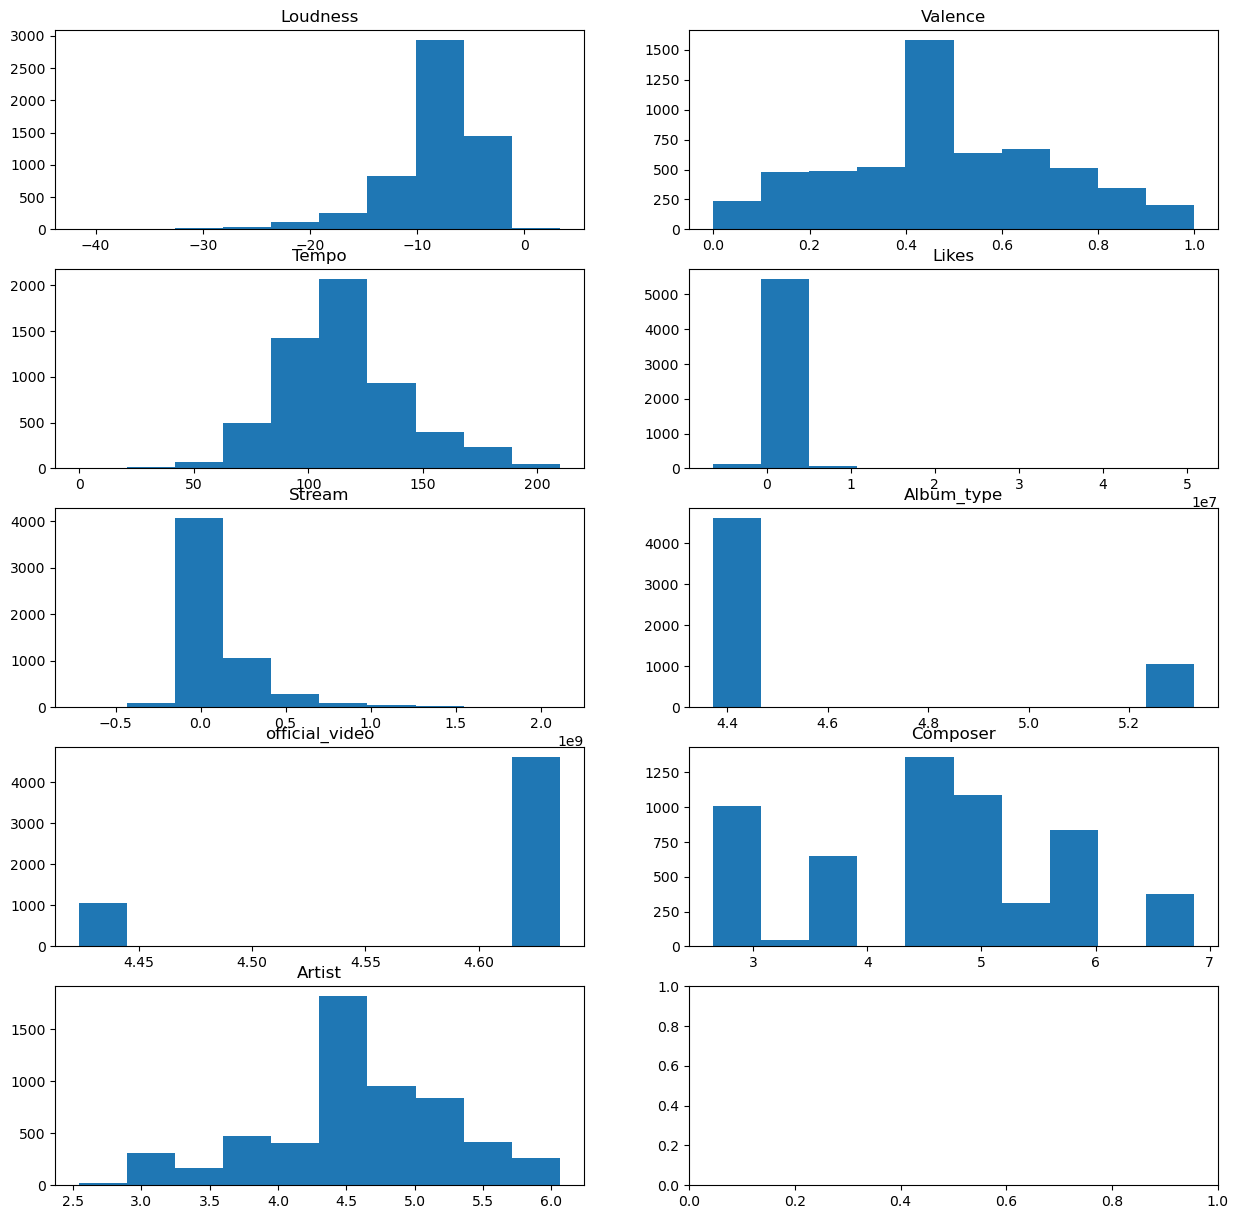

In [94]:
# to see the distribution
import matplotlib.pyplot as plt

n_features = len(ttest_x.columns)
n_rows = 5
n_cols = int(n_features / n_rows) + (n_features % n_rows > 0)

fig, axs = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = (15, 15))
axs = axs.flatten()

for i, col in enumerate(ttest_x.columns):
    axs[i].hist(ttest_x[col])
    axs[i].set_title(col)

plt.show()

# Step 2: Data Transformation & Feature Selection

# Step 3: Model Prediction

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(ttrain_x, train_y, test_size = 0.17, random_state = 1705)

X_train

,Loudness,Valence,Tempo,Likes,Stream,Album_type,official_video,Composer,Artist
15798,-13.045000,0.762000,113.012,489121.0,27975864.0,4.372986,4.635585,4.800193,4.401392
10527,-7.658000,0.752000,114.926,8893049.0,239674920.0,4.372986,4.635585,5.147425,4.478453
1930,-7.058000,0.649000,122.327,1085093.0,62908755.0,4.390925,4.635585,5.269945,5.046575
7578,-11.890000,0.597000,173.941,2845.0,6325282.0,4.372986,4.635585,4.478504,4.478453
9236,-9.456000,0.096900,130.924,56437.0,22704502.0,5.327816,4.635585,3.870229,3.481308
...,...,...,...,...,...,...,...,...,...
8949,-3.467000,0.584000,115.013,105757.0,3513820.0,4.372986,4.635585,3.870229,4.998051
12905,-7.346000,0.784000,117.486,23581.0,15767609.0,5.327816,4.635585,3.870229,5.395604
4099,-4.681178,0.779570,87.452,284869.0,10123718.0,4.372986,4.635585,3.870229,4.723849
14715,-4.966000,0.610403,156.989,4140410.0,92694964.0,5.327816,4.423852,5.918457,5.149669


In [39]:
# try any models
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn import neighbors, svm, naive_bayes
from sklearn.neural_network import MLPClassifier

model = Ridge(alpha = 1)
model.fit(ttrain_x, train_y)

y_pred = model.predict(val_x)

y_pred = y_pred.round()
y_pred[y_pred > 9] = 9
y_pred[y_pred <= 0] = 0

e = mean_absolute_error(val_y, y_pred)
e

# print('done')

2.0380348652931852

In [40]:
# ordinal logistic regression
# !pip install mord
from mord import LogisticIT, LogisticAT, LogisticSE

model = LogisticAT(alpha = 1)
model.fit(ttrain_x, train_y.astype(int))

y_pred = model.predict(val_x)

y_pred = y_pred.round()
y_pred[y_pred > 9] = 9
y_pred[y_pred <= 0] = 0

e = mean_absolute_error(val_y, y_pred)
e

# print('done')

3.179080824088748

In [74]:
param_grid = {
#     'gamma':[0],
    'sub_sample':[0.35],
    'learning_rate': [0.01],
    'max_depth': [10],
    'alpha':[0.26],
    'n_estimators': [400, 420, 450, 480],
#     'random_state': [1705],
#     'test_size': [0.15, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22],
}

e = 100
for learning_rate in param_grid['learning_rate']:
    for max_depth in param_grid['max_depth']:
        for sub_sample in param_grid['sub_sample']:
            for n_estimators in param_grid['n_estimators']:
                
                model = xg.XGBRegressor(objective = 'reg:squarederror',
                                        gamma = 0,
                                        subsample = sub_sample,
                                        alpha = 0.26,
                                        max_depth = max_depth,
                                        learning_rate = learning_rate,
                                        eval_metric = 'mae',
                                        n_estimators = n_estimators,
                                        random_state = 1705
                                        )

                model.fit(ttrain_x, train_y)
                y_pred = model.predict(val_x)
                
                y_pred = y_pred.round()
                y_pred[y_pred > 9] = 9
                y_pred[y_pred <= 0] = 0

                mae = mean_absolute_error(val_y, y_pred)

                print(f"Parameters: max_depth = {max_depth}, learning_rate = {learning_rate}, sub_sample = {sub_sample}, alpha = {n_estimators}")
                print(f"MAE: {mae}\n-----------------")

                if mae < e:
                    e = mae
                    best_params = [max_depth, learning_rate, sub_sample, n_estimators]

print(f'Best MAE = {e}')
print(f'Best Params = {best_params}')

Parameters: max_depth = 10, learning_rate = 0.01, sub_sample = 0.35, alpha = 400
MAE: 2.0443740095087164
-----------------
Parameters: max_depth = 10, learning_rate = 0.01, sub_sample = 0.35, alpha = 420
MAE: 2.050713153724247
-----------------
Parameters: max_depth = 10, learning_rate = 0.01, sub_sample = 0.35, alpha = 450
MAE: 2.0570522979397783
-----------------
Parameters: max_depth = 10, learning_rate = 0.01, sub_sample = 0.35, alpha = 480
MAE: 2.058637083993661
-----------------
Best MAE = 2.0443740095087164
Best Params = [10, 0.01, 0.35, 400]


In [43]:
# XGBoost
import xgboost as xg
from sklearn.metrics import mean_absolute_error

model = xg.XGBRegressor(objective = 'reg:squarederror', subsample = 0.35, alpha = 0.26, learning_rate =  0.01, max_depth = 10, eval_metric = 'mae', n_estimators = 400, random_state = 1705)
model.fit(ttrain_x, train_y)

y_pred = model.predict(val_x)

y_pred = y_pred.round()
y_pred[y_pred > 9] = 9
y_pred[y_pred <= 0] = 0

e = mean_absolute_error(val_y, y_pred)

print(e)
# print('done')

2.0443740095087164


In [108]:
diff = pd.DataFrame(X_test, columns = ttrain_x.columns)
diff['pred'] = y_pred
diff['real'] = y_test

y_pred = y_pred.round()
y_pred[y_pred > 9] = 9
y_pred[y_pred <= 0] = 0

diff['diff'] = y_pred - y_test
diff

,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Views,...,Stream,Comments,Description,Album_type,official_video,Composer,Artist,pred,real,diff
6782,0.665339,-6.114,0.0368,0.007301,0.020500,0.004096,0.643,138.892,191253.0,31078652.0,...,45532240.0,12113.0,401,4.396383,4.649987,4.842133,5.044379,4.775497,4,1.0
1546,0.047046,-14.398,0.0499,0.241804,0.001190,0.003652,0.612,187.711,152867.0,8145894.0,...,142956049.0,NaN,96,4.370472,4.649987,2.630402,4.547030,1.275071,0,1.0
2902,0.012978,-13.816,0.0411,0.707348,NaN,0.001225,0.252,82.511,NaN,77179288.0,...,17060305.0,21091.0,123,5.356809,4.649987,4.842133,4.547030,1.917336,0,2.0
14027,0.140608,-7.138,0.1290,0.000106,0.000000,0.000636,0.564,111.023,183000.0,74713341.0,...,62997890.0,31191.0,7,5.356809,4.412908,4.507585,4.547030,8.413127,9,-1.0
1266,0.313047,-7.363,NaN,0.202262,0.000000,0.004492,NaN,NaN,235493.0,3662920.0,...,81237570.0,1133.0,218,4.370472,4.412908,6.888787,4.864807,5.280558,6,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2387,NaN,-6.739,0.0672,0.000915,0.000012,0.001368,0.346,129.435,NaN,23400485.0,...,17546347.0,2001.0,71,4.370472,4.649987,3.862981,5.580087,5.520092,4,2.0
4236,NaN,-9.905,0.0314,0.485588,NaN,0.001030,0.276,NaN,242400.0,608137.0,...,6948833.0,195.0,21,4.370472,4.412908,2.630402,5.121212,1.183083,2,-1.0
8749,0.058864,-5.727,0.0337,0.181321,0.000000,0.000564,0.244,NaN,147597.0,10578526.0,...,53333134.0,16156.0,320,4.396383,4.649987,2.630402,5.520833,2.328217,4,-2.0
9918,0.029791,-10.843,0.0447,0.498677,0.000000,0.001260,0.480,188.155,228253.0,NaN,...,153771619.0,9299.0,96,4.370472,4.649987,2.630402,4.225806,0.822797,4,-3.0


In [93]:
diff.to_csv('diff.csv', index = False)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

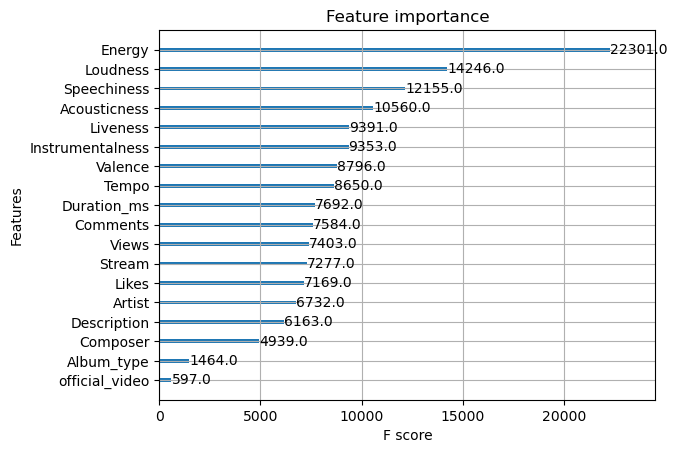

In [20]:
# feature importance
import matplotlib.pyplot as plt
# imp = pd.DataFrame([ttrain_x.columns, model.feature_importances_]).T
imp = xg.plot_importance(model)

# plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
# plt.show()

imp

# Step 4: Submit the Prediction

In [77]:
# XGBoost
import xgboost as xg

test_y = model.predict(ttest_x)

test_y

array([4.626361 , 6.199236 , 3.41095  , ..., 2.190692 , 6.839964 ,
       4.8827434], dtype=float32)

In [78]:
test_y = test_y.round()
test_y[test_y > 9] = 9
test_y[test_y <= 0] = 0

test_y

array([5., 6., 3., ..., 2., 7., 5.], dtype=float32)

In [79]:
output_y = pd.DataFrame({'id':np.array(ttest_x_id), 'Danceability': test_y})
output_y = pd.concat([test_partial_answer, output_y])

output_y.sort_values(by = 'id', inplace = True)
output_y.reset_index(drop = True, inplace = True)

output_y.to_csv('submission.csv', index = False)
output_y

,id,Danceability
0,17170,5.0
1,17171,6.0
2,17172,3.0
3,17173,4.0
4,17174,6.0
...,...,...
6310,23480,2.0
6311,23481,7.0
6312,23482,3.0
6313,23483,5.0


In [80]:
output_y['Danceability'].value_counts()

5.0    1206
4.0    1184
3.0     975
6.0     943
2.0     693
7.0     601
1.0     316
8.0     208
0.0     100
9.0      89
Name: Danceability, dtype: int64

In [ ]:
sample_submission['Danceability'] = output_y
sample_submission.to_csv('submission.csv', index = False)

In [50]:
sample_submission['Danceability'].value_counts()

5.0    1097
4.0    1095
6.0     975
3.0     924
2.0     727
7.0     683
1.0     359
8.0     316
0.0      94
9.0      45
Name: Danceability, dtype: int64